# Jamoembedding Hangul Deeplearning Project



Course : 2023-1 DLIP Final project

Student ID : 21800031 

Name : Kook Jinho

Date : 2023-06-16






First, you have to set virtual enviroment that I provided and install requirements. But I provided yaml file that includes setting value. You just use it in ANACONDA.



Follow this:

conda env create -f DLIP_GPU.yaml

conda activate DLIP_GPU

* This format is optimized for CUDA 11.3 and PYTHON 3.9. Anything other than this format may cause errors.
* If you want a different format, create new enviroment(PYTHON), install 'requirements.txt' and install the other necessary files.
* tensorflow 1.X is not recommand. And if you use tensorflow cpu version, train speed is very low.


I recommand setup the 'DLIP_GPU' yaml format file.
This format is optimized for CUDA 11.3 and PYTHON 3.9. Anything other than this format may cause errors.
If you want a different format, install requirements.txt and install the other necessary files.

In [8]:
#Module setting
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import matplotlib.font_manager as fm
from pathlib import Path
import matplotlib.patches as mpatches
import matplotlib as mpl

# Root setting
# enter your root path below.
BASE_PATH = "C:/Users/ririk/Desktop/DLIP_Final_Project/ocr-text-recognition-korean-master/ocr-text-recognition-korean-master"
sys.path.append(BASE_PATH)

## 1. Dataset setting
##### (1) Using Hangul word dictionary dataset 

In [9]:
# range of the words
min_words = 2
max_words = 8
# I got the list from a word dictionary.
# df = dataframe
df = pd.read_csv(os.path.join(BASE_PATH, "./datasets/wordslist.txt"),
                 names=['word'])
df = df.drop_duplicates()
df = df[df.word.str.match(r'^[가-힣]+$')]
df = df[
    df.word.map(
        lambda x: (len(x) >= min_words) 
        and (len(x) <= max_words))]
#print(df)
#print("\n------------------------------------\n")
# df is n * 1(words;colomn) matrix.
words = df.word.values
np.random.shuffle(words)
# words is the list of korean words.
words
#print(words)
#print("\n------------------------------------\n")
#print("number of words : ",len(words))

array(['조령석개', '파르당당하다', '보이스', ..., '배큰속벌레', '옷고름고', '절협과'], dtype=object)

In [10]:
#data augmentation
import random

def concatenate_words(words):
    concatenated_list = []
    for _ in range(1000000):
        random_index1 = random.randint(0, len(words) - 1)
        random_index2 = random.randint(0, len(words) - 1)
        random_words = [words[random_index1], words[random_index2]]
        concatenated_word = ''.join(random_words)
        concatenated_list.append(concatenated_word)
    return concatenated_list

new_list = concatenate_words(words)
#print("number of new words :", len(new_list))
#words = np.concatenate((words, new_list))
words = new_list
#print(words)
#print("\n------------------------------------\n")
print("number of total words :", len(words))

number of total words : 1000000


##### (2) Convert text  to image for datasets

dataset number =  1000000
낙방거자몽고문


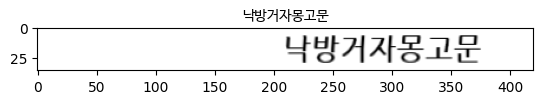

In [ ]:
# just title font setting.
font_path = "./font/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=10)

from utils.dataset import OCRDataset
dataset = OCRDataset(words, font_size=24)
# random image printing
random_number = random.randint(0, 100000)
#get image and label from dataset
image, label = dataset[random_number]
# number of data
datasetnumber = len(dataset)
print("dataset number = ", datasetnumber)
#test image print
plt.title(label,fontproperties=fontprop)
print(label)
plt.imshow(image[:,:,0],cmap='gray')
plt.show()

['NanumGothic']
 total dataset = 1000000
 validation dataset = 50000
 train dataset = 950000
train gen =  237500
valid gen =  12500


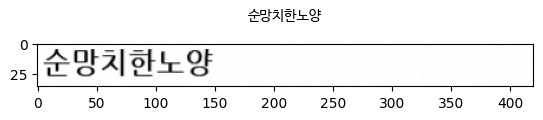

In [12]:
#-*-coding:utf-8-*-
from utils.generator import JAMOSeq2SeqGenerator
from functools import partial
from models.jamo import compose_unicode

# Only use Nanum font. the other fonts make error. 
FONT_LIST = [f.name for f in fm.fontManager.ttflist]
FONT_LIST = list(
   set([f for f in FONT_LIST if "Nanum" in f ]))
print(FONT_LIST)

# OCRDataset setting
# dataset consist in only 1 font.
OCRDataset = partial(OCRDataset,
                     font_size=24,
                     bg_noise=0.02,
                     affine_noise=(0.0,0.02),
                     normalize=False,
                     random_shift=False,                     
                     color_noise=(0.0,0.02),
                     gray_scale=True,
                     font_list=FONT_LIST,
                     )

import random
# Shuffle the words list
random.shuffle(words)

# train : validation = 95 : 5 
valid_words = words[:len(words)*5//100]
train_words = words[len(words)*5//100:]
train_words = train_words
print(" total dataset =", len(words))
print(" validation dataset =", len(valid_words))
print(" train dataset =", len(train_words))

valid_set = OCRDataset(valid_words)
train_set = OCRDataset(train_words)
print(train_set)

train_gen = JAMOSeq2SeqGenerator(train_set, batch_size=4)
valid_gen = JAMOSeq2SeqGenerator(valid_set, batch_size=4)
print("train gen = ", len(train_gen))
print("valid gen = ", len(valid_gen))
X = train_gen[0][0]
for i in range(1):
    image = X['images'][i,:,:,0]
    plt.title(compose_unicode(X['output_sequences'][i])[0],fontproperties=fontprop)
    #print(image.shape)
    plt.imshow(image,cmap='gray')
    plt.show()
    

## 2. Configure GRU model
##### (1) Configure Image Feature Extractor


In [13]:
from models.layers import ResidualConvFeatureExtractor
from tensorflow.keras.layers import Input

K.clear_session()

height = 36

n_conv = 16   # the number of Convolution filter
n_state = 256 # the number of GRU units
n_embed = 16  # the size of embedding vector
n_clf = 256   # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(height, None, 1),name='images')
conv_maps = ResidualConvFeatureExtractor(n_conv,
                                         name='feature_extractor')(inputs)

##### (2) Configure Map2Sequence

In [7]:
from models.layers import Map2Sequence

feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)

##### (3) Configure Embedding Layer
convert text to embedding number. 

teacherforcing : delay time step of input value.

'JamoEmbedding' used.
* Jamoembeding : How consonants and vowels in Hangul are separated and assigned separately. In used Hangul only.

In [8]:
from models.layers import JamoEmbedding, TeacherForcing

# TeacherForcing training
y_true = Input(shape=(None,), dtype=tf.int32, name='output_sequences')
decoder_inputs = TeacherForcing()(y_true)

jamo_embedding_layer = JamoEmbedding(n_embed)
jamo_embedding = jamo_embedding_layer(decoder_inputs)

##### (4) Configure Text Decoder Layer

In [9]:
from tensorflow.keras.layers import GRU

# Text Decoder
gru_layer = GRU(n_state, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(jamo_embedding)

##### (5) Configure Attention Layer  

In [10]:
from models.layers import DotAttention
from tensorflow.keras.layers import Concatenate

dotattend = DotAttention(n_state=n_state)
context, attention = dotattend([feature_seqs, states_decoder])

concat_state = Concatenate(axis=-1, name='concat_output')(
    [context, states_decoder])

##### (6) Configure Character Classification Layer

In [11]:
from models.layers import JamoClassifier

# Classifier Layer
jamo_clf = JamoClassifier(n_clf, name='output_seqs')
y_pred = jamo_clf(concat_state)

##### (7) Configure Loss Layer

In [12]:
from models.losses import JamoCategoricalCrossEntropy

loss = JamoCategoricalCrossEntropy(blank_value=-1.)([y_true, y_pred])

##### (8) Configure Train Model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# For training
trainer = Model([inputs, y_true],[loss], name='trainer')
trainer.add_loss(loss)

# Compile model
trainer.compile(Adam(lr=1e-2))

c:\Users\ririk\anaconda3\envs\DLIP_GPU\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


 ##### (9) Train

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from multiprocessing import cpu_count
from utils.generator import JAMOSeq2SeqGenerator
from tensorflow.keras.callbacks import EarlyStopping

callbacks =[]
rlrop = ReduceLROnPlateau(
    factor=0.5, patience=2, 
    min_lr=1e-5, verbose=1,cooldown=5, monitor='loss')
callbacks.append(rlrop)

#set epoch number
epochs = 100

# I recommand batch size number over 64 
train_gen = JAMOSeq2SeqGenerator(train_set.config, batch_size=128)
valid_gen = JAMOSeq2SeqGenerator(valid_set.config, batch_size=128)

# Earystopping code on loss
early_stopping = EarlyStopping(patience=2, monitor='loss',mode='min', min_delta=0.02, verbose=1)
callbacks.append(early_stopping)

In [15]:
#train model

hist = trainer.fit(train_gen, steps_per_epoch=1000,                               
                             epochs=epochs, callbacks=callbacks,
                             use_multiprocessing=True, 
                             workers=cpu_count())

Epoch 1/100
1000/1000 [==============================] - 383s 330ms/step - loss: 6.2008
Epoch 2/100
1000/1000 [==============================] - 582s 543ms/step - loss: 5.2203
Epoch 3/100
1000/1000 [==============================] - 442s 402ms/step - loss: 1.7354
Epoch 4/100
1000/1000 [==============================] - 320s 282ms/step - loss: 0.6734
Epoch 5/100
1000/1000 [==============================] - 324s 288ms/step - loss: 0.4124
Epoch 6/100
1000/1000 [==============================] - 356s 319ms/step - loss: 0.3326
Epoch 7/100
1000/1000 [==============================] - 422s 382ms/step - loss: 0.2868
Epoch 8/100
1000/1000 [==============================] - 442s 402ms/step - loss: 0.2672
Epoch 9/100
1000/1000 [==============================] - 459s 420ms/step - loss: 0.2149
Epoch 10/100
1000/1000 [==============================] - 534s 495ms/step - loss: 0.2035
Epoch 11/100
1000/1000 [==============================] - 419s 380ms/step - loss: 0.1938
Epoch 12/100
1000/1000 [======

In [16]:
# --------------------------------------------------Do not run this !------------------------------------------------- 
#############################
#  If you want using only CPU or occur error, using this code. But it will take time very long.. 
# hist = trainer.fit_generator(train_gen, steps_per_epoch=1000,                               
#                              epochs=epochs, callbacks=callbacks)
#############################

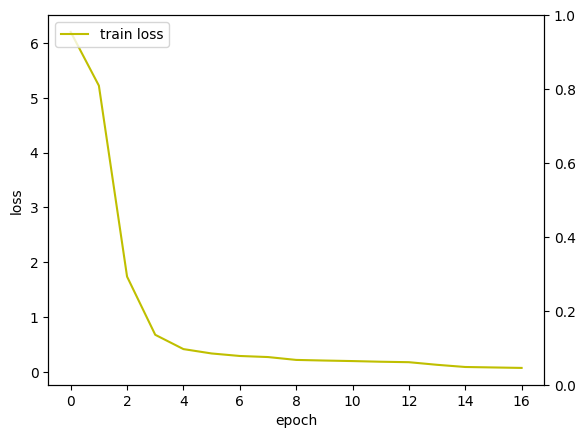

In [17]:
# plot progress of training

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()

In [18]:
#Save model
from tensorflow.keras.models import save_model


save_model(trainer, 'trained_model.h5')

# Another save method#

# import tensorflow as tf
# tf.saved_model.save(trainer, 'saved_model')

In [19]:
# #Load model
# from tensorflow.keras.models import load_model


# trainer = load_model('trained_model.h5')
#Model = trainer
# Another method
# trainer = tf.saved_model.load('saved_model')



## 3. Infer Model
##### (1) Mount Validation Data 

In [20]:
X, = valid_gen[0]
print(len(valid_gen[0]))
# Target image 
target_images = X['images'][:10]
#print(target_images)
#print(len(target_images))
print(target_images.shape)

1
(10, 36, 420, 1)


##### (2) Encoding Image and Decoding Text

In [21]:
from models.layers import JamoCompose

# - (1) Encoder
encoder = Model(inputs, feature_seqs, 
                name='encoder')
num_feature = feature_seqs.shape.as_list()[-1]
#num_feature = np.array(feature_seqs).shape.as_list()[-1]

# - (2) Decoder
states_encoder_input = Input((None, num_feature),
                             name='states_encoder_input')
decoder_state_inputs = Input(shape=(n_state,), name='decoder_state')
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

jamo_embedding = jamo_embedding_layer(decoder_inputs)
states_decoder = gru_layer(jamo_embedding,
                           initial_state=decoder_state_inputs)
context, attention = dotattend([states_encoder_input,
                                states_decoder])
concat_state = Concatenate(axis=-1,name='concat_output')(
    [context, states_decoder])
predictions = jamo_clf(concat_state)
output_decoder = JamoCompose(name='jamocompose')(predictions)

decoder = Model([states_encoder_input,
                 decoder_inputs,
                 decoder_state_inputs], 
                [states_decoder, output_decoder], name='decoder')

In [22]:
# Calculate encoder results
states_encoder_ = encoder.predict(target_images)

EOS_TOKEN = ord('\n') # <EOS> token

# Decoder
batch_size = target_images.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, n_state))

result = np.zeros([batch_size,0])

while True:

    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = predictions_
    
    result = np.concatenate([result, prev_inputs], axis=-1)
    
    print(result)

    if np.all(np.any(result==EOS_TOKEN,axis=1)):
        break

result = result[:,:].squeeze()
result = result.astype(np.int)

[[51088.]
 [48373.]
 [49901.]
 [51201.]
 [48516.]
 [44628.]
 [49549.]
 [44396.]
 [49328.]
 [47924.]]
[[51088. 44592.]
 [48373. 51109.]
 [49901. 51088.]
 [51201. 51665.]
 [48516. 44284.]
 [44628. 51704.]
 [49549. 51060.]
 [44396. 47693.]
 [49328. 51201.]
 [47924. 47141.]]
[[51088. 44592. 50997.]
 [48373. 51109. 47564.]
 [49901. 51088. 47196.]
 [51201. 51665. 54633.]
 [48516. 44284. 44032.]
 [44628. 51704. 45908.]
 [49549. 51060. 50808.]
 [44396. 47693. 46758.]
 [49328. 51201. 54868.]
 [47924. 47141. 51613.]]
[[51088. 44592. 50997. 51088.]
 [48373. 51109. 47564. 45285.]
 [49901. 51088. 47196. 50612.]
 [51201. 51665. 54633. 44169.]
 [48516. 44284. 44032. 50517.]
 [44628. 51704. 45908. 44648.]
 [49549. 51060. 50808. 51901.]
 [44396. 47693. 46758. 44592.]
 [49328. 51201. 54868. 47932.]
 [47924. 47141. 51613. 54624.]]
[[51088. 44592. 50997. 51088. 50516.]
 [48373. 51109. 47564. 45285. 54032.]
 [49901. 51088. 47196. 50612. 50836.]
 [51201. 51665. 54633. 44169. 47785.]
 [48516. 44284. 44032. 5

C:\Users\ririk\AppData\Local\Temp\ipykernel_7632\2541811225.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = result.astype(np.int)


##### (3) Show Images

10


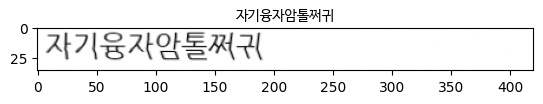

10


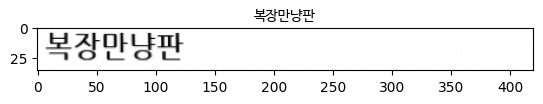

10


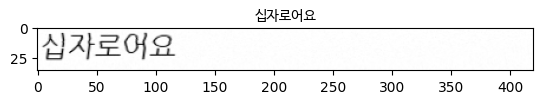

10


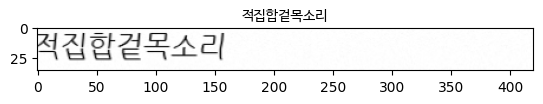

10


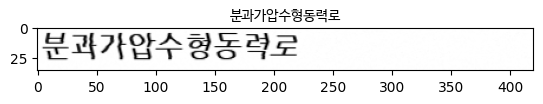

10


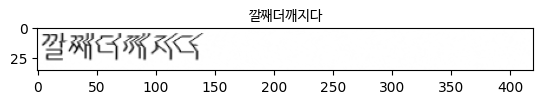

10


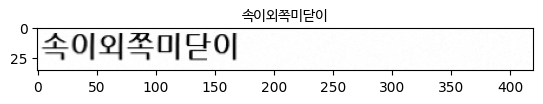

10


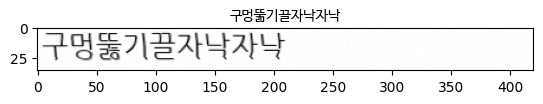

10


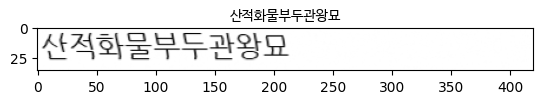

10


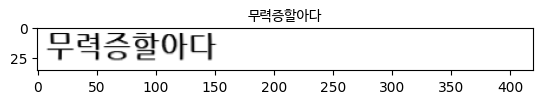

In [23]:
for image, seq in zip(target_images, result):

    #print(seq)
    text_seq = "".join([chr(char) for char in seq])
    print(len(text_seq))
    text_seq = text_seq.split('\n')[0]

    plt.title(text_seq,fontproperties=fontprop)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()

## 4. Demo test


##### (1) Bring the test images


I use 'word generator' to test. 

*warning !!*

word length matched max ( In this case, 16). It decides length size of the image.

50
50
(50, 36, 420, 1)


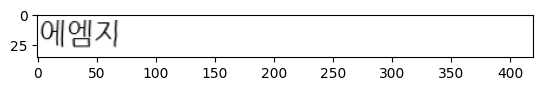

In [14]:
#-*-coding:utf-8-*-
from utils.generator import JAMOSeq2SeqGenerator
from functools import partial
from models.jamo import compose_unicode

# Only use Nanum font. the other fonts make error. 
FONT_LIST = [f.name for f in fm.fontManager.ttflist]
FONT_LIST = list(
   set([f for f in FONT_LIST if "Nanum" in f ]))

# OCRDataset setting
# dataset consist in only 1 font.
OCRDataset = partial(OCRDataset,
                     font_size=24,
                     bg_noise=0.0,
                     affine_noise=(0.0,0.01),
                     normalize=False,
                     random_shift=False,                     
                     color_noise=(0.0,0.01),
                     gray_scale=True,
                     font_list=FONT_LIST,
                     )

 
test_words = ['안녕','드래곤','로드','올드','타운','시티캣','보급','창고','해양','중개소','마블',
              '아머리','마리','골드','타운','영구','에이','케이','시그','노블','이블','더블','삼거리','광계', '가나다라마바사아자차카타파하오나',
              '하다','에엠지','뉴턴','교근','티에이','교수님','웨폰','챌린지','학기말', '기말고사', '치코', '파닭', '포스텍', '한동대', '대학원',
               '가기', '구르카', '몽키', '가든', '외쳐', '같이가요', '혼자가기', '싫어요','레츠고','쇼타임' ]

test_set = OCRDataset(test_words)



print(test_set)
print(len(test_words))
print(len(test_set))
test_gen = JAMOSeq2SeqGenerator(test_set, batch_size=50)
Z,  = test_gen[0]

test_images = Z['images'][:]

print(test_images.shape)

image_gray = test_images[1, :, :, :]  
plt.imshow(image_gray, cmap='gray')
plt.show()


##### This code save the test images

In [33]:
import cv2
import os
import numpy as np

# Load the images
image = Z['images'][:]
print(image.shape)

# Specify the folder path to save the images
output_folder = 'C:/Users/ririk/Desktop/DLIP_Final_Project/easyocr_test_image'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the images
for i in range(len(image)):
    # Set the image file name
    filename = f'image{i+1}.jpg'

    # Convert the image to 2D
    img_2d = image[i].squeeze()

    # Normalize the image values to the range of 0 and 1
    img_normalized = (img_2d - np.min(img_2d)) / (np.max(img_2d) - np.min(img_2d))

    # Check the data type of the image and convert if necessary
    if img_normalized.dtype != np.uint8:
        img_normalized = (img_normalized * 255).astype(np.uint8)

    # Check the color mode of the image and convert grayscale images to BGR
    if len(img_normalized.shape) == 2:
        img_bgr = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2BGR)
    else:
        img_bgr = img_normalized

    # Save the image
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, img_bgr)

    # Read the saved image and display it
    saved_img = cv2.imread(output_path)
    cv2.imshow('Saved Images', saved_img)
    cv2.waitKey(0)

cv2.destroyAllWindows()

(50, 36, 420, 1)


##### (2) Infer for test images

In [25]:
# Calculate encoder results
states_encoder_ = encoder.predict(test_images)

EOS_TOKEN = ord('\n') # <EOS> token

# Decoder

batch_size = test_images.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, 256))
# prev_states = np.zeros((batch_size, 64))
result = np.zeros([batch_size,0])

while True:

    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = predictions_
    
    result = np.concatenate([result, prev_inputs], axis=-1)
    
    print(result)

    if np.all(np.any(result==EOS_TOKEN,axis=1)):
        break

result = result[:,:].squeeze()
result = result.astype(np.int)

[[52992.]
 [49884.]
 [48372.]
 [53440.]
 [54617.]
 [47560.]
 [45684.]
 [50808.]
 [49340.]
 [44368.]
 [44032.]
 [47805.]
 [47196.]
 [47560.]
 [50920.]
 [54620.]
 [50640.]
 [50640.]
 [51088.]
 [53440.]
 [51060.]
 [54028.]
 [44592.]
 [54644.]
 [44368.]
 [50500.]
 [50732.]
 [49660.]
 [54000.]
 [54616.]
 [52300.]
 [44264.]
 [44032.]
 [45824.]
 [54252.]
 [52285.]
 [45432.]
 [46300.]
 [50504.]
 [49884.]
 [44396.]
 [49911.]
 [50689.]
 [44057.]
 [45908.]
 [47112.]
 [52824.]
 [44305.]
 [54844.]
 [51473.]]
[[52992. 51060.]
 [49884. 44536.]
 [48372. 44553.]
 [53440. 50868.]
 [54617. 44592.]
 [47560. 48660.]
 [45684. 53556.]
 [50808. 52432.]
 [49340. 44144.]
 [44368. 44540.]
 [44032. 44592.]
 [47805. 53412.]
 [47196. 46300.]
 [47560. 47532.]
 [50920. 54256.]
 [54620. 46041.]
 [50640. 50656.]
 [50640. 51060.]
 [51088. 45208.]
 [53440. 50868.]
 [51060. 48660.]
 [54028. 45805.]
 [44592. 47568.]
 [54644. 50577.]
 [44368. 49688.]
 [50500. 47672.]
 [50732. 46300.]
 [49660. 53440.]
 [54000. 50640.]
 [5461

C:\Users\ririk\AppData\Local\Temp\ipykernel_7632\580086984.py:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = result.astype(np.int)


277


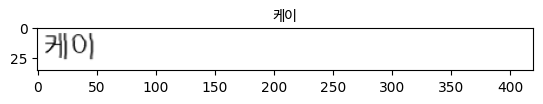

277


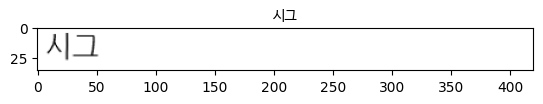

277


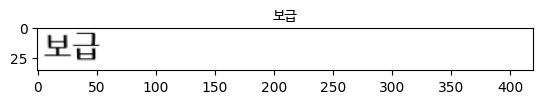

277


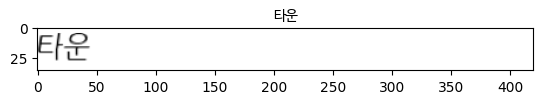

277


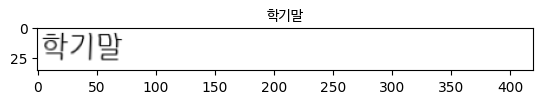

277


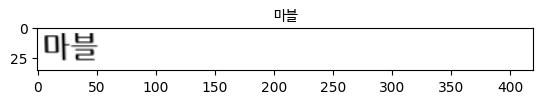

277


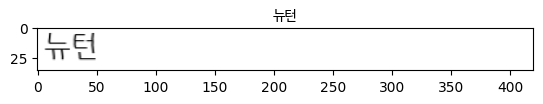

277


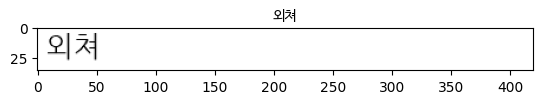

277


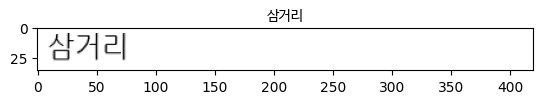

277


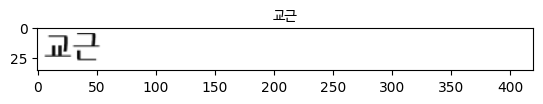

277


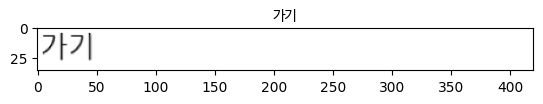

277


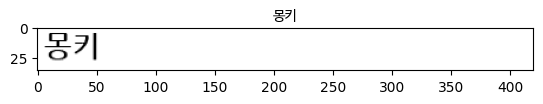

277


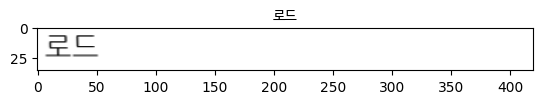

277


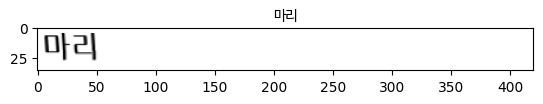

277


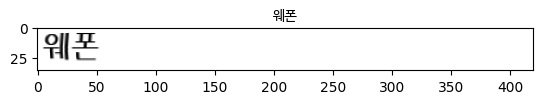

277


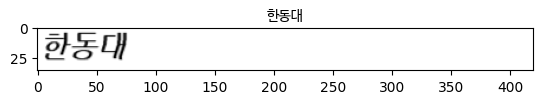

277


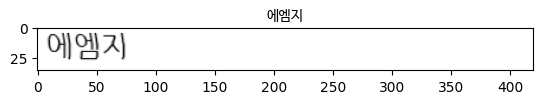

277


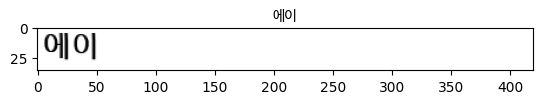

277


c:\Users\ririk\anaconda3\envs\DLIP_GPU\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 55204 (\ud7a4) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ririk\anaconda3\envs\DLIP_GPU\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 55232 (\N{HANGUL JUNGSEONG I-YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


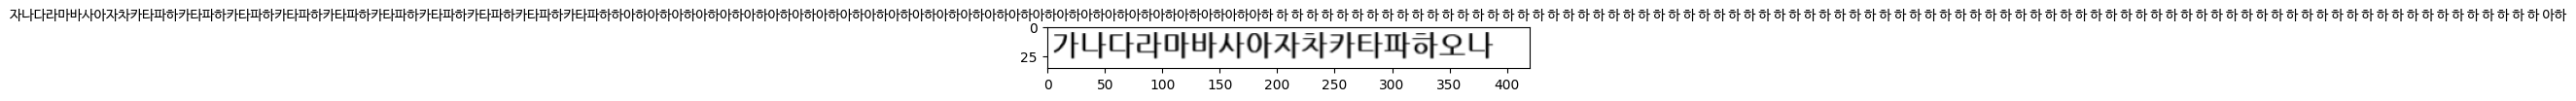

277


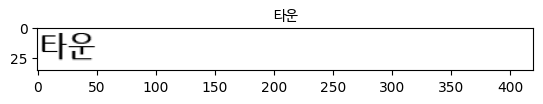

277


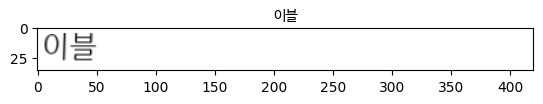

277


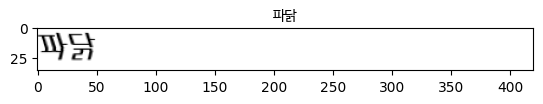

277


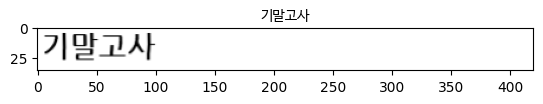

277


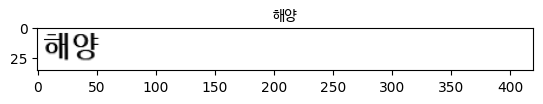

277


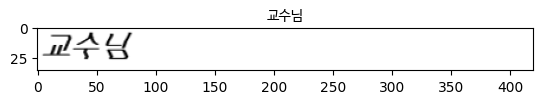

277


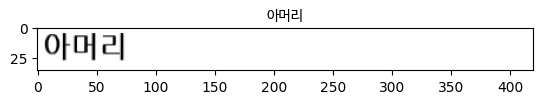

277


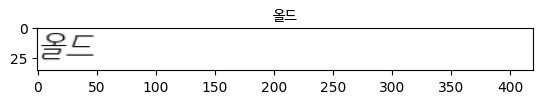

277


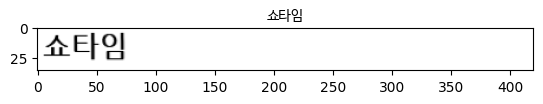

277


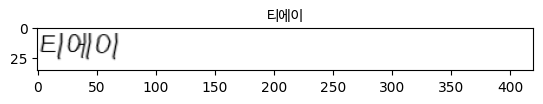

277


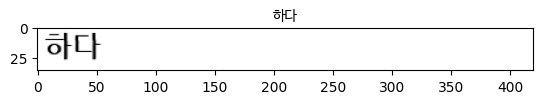

277


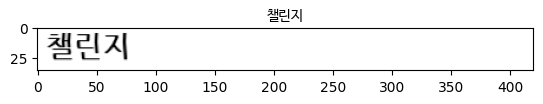

277


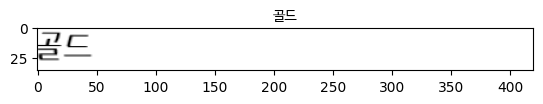

277


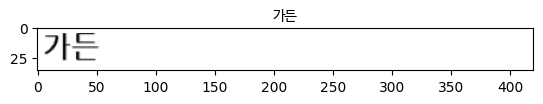

277


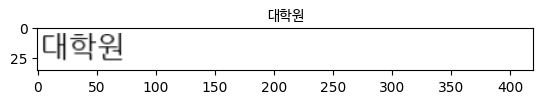

277


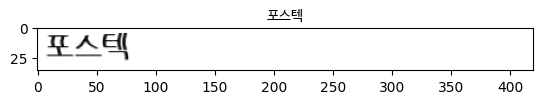

277


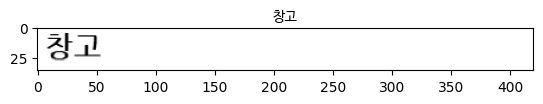

277


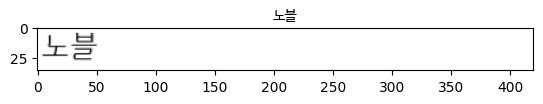

277


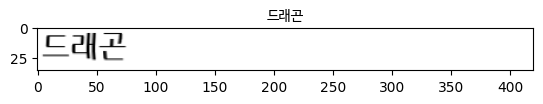

277


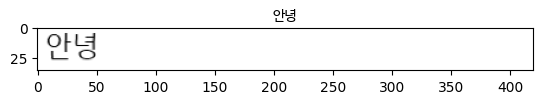

277


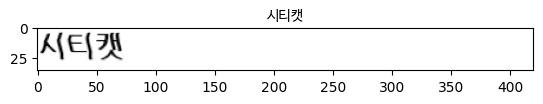

277


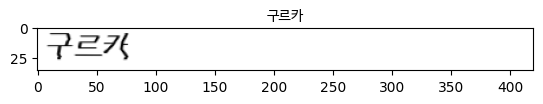

277


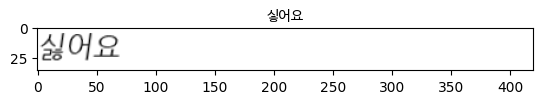

277


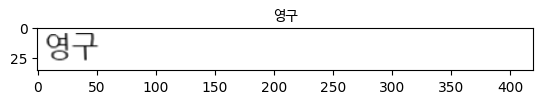

277


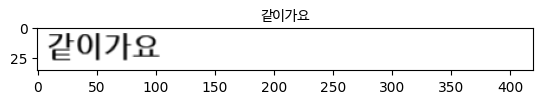

277


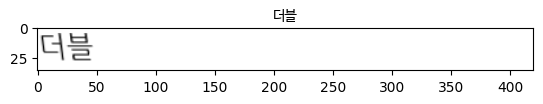

277


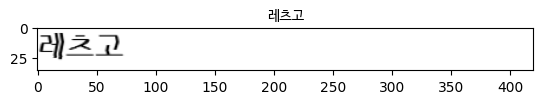

277


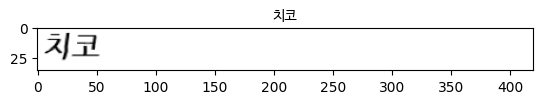

277


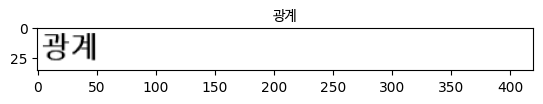

277


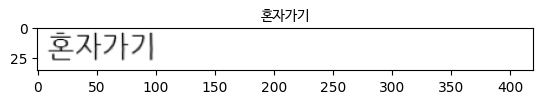

277


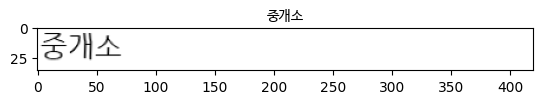

In [26]:
for image, seq in zip(test_images, result):

    #print(seq)
    text_seq = "".join([chr(char) for char in seq])
    print(len(text_seq))
    text_seq = text_seq.split('\n')[0]

    plt.title(text_seq,fontproperties=fontprop)
    plt.imshow(image[:,:,:],cmap='gray')
    plt.show()

## 4. Demo test 2 - OPENCV processing image


##### (1) Bring the test images


I bring all files in 'cropped_img'. And convert format of images.

You can change image format or image style in 'image_processing.py'.

### (1) Bring corpped image

8


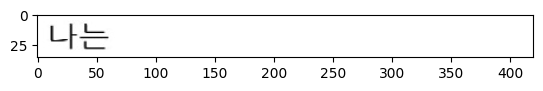

(8, 36, 420, 1)


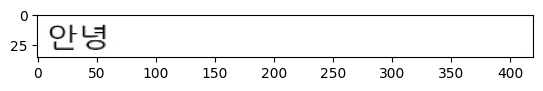

In [141]:
import cv2
import os

# Your file directory
folder_path = 'C:/Users/ririk/Desktop/DLIP_Final_Project/cropped_img'

image_files = os.listdir(folder_path)  # Get all file names in the folder

image_list = []  # List to store the images

# Iterate through the image file list and load the images into the list
for file_name in image_files:
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        # Process only image files (you can filter based on the extension)
        image_path = os.path.join(folder_path, file_name)  # Image file path
        image = cv2.imread(image_path)  # Read the image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert BGR image to grayscale
        gray_image = np.expand_dims(gray_image, axis=2)  # Add channel dimension to make it (36, 420, 1)

        shift_amount = -3
        image_shifted = np.roll(gray_image, shift_amount, axis=0)
        # image_shifted[:shift_amount, :] = 0

        gray_image = image_shifted

        shift_amount = -6
        image_shifted = np.roll(gray_image, shift_amount, axis=1)
        # image_shifted[:shift_amount, :] = 0

        gray_image = image_shifted

        image_list.append(gray_image)  # Add the image to the list

# Convert the image list to the shape (total number of images, 36, 420, 1)
image_array = np.stack(image_list, axis=0)

print(len(image_array))
plt.imshow(image_array[1], cmap='gray')
plt.show()
print(image_array.shape)

image_gray = image_array[0, :, :, :]  # Assuming it's a grayscale image, removing the channel dimension
plt.imshow(image_gray, cmap='gray')
plt.show()



### (2) Encoding and decoding

[[45208.]
 [45768.]
 [46373.]
 [49688.]
 [44032.]
 [48148.]
 [48372.]
 [48148.]]
[[4.5208e+04 4.5341e+04]
 [4.5768e+04 4.5716e+04]
 [4.6373e+04 5.5120e+04]
 [4.9688e+04 5.0629e+04]
 [4.4032e+04 5.0864e+04]
 [4.8148e+04 5.0864e+04]
 [4.8372e+04 1.0000e+01]
 [4.8148e+04 5.1060e+04]]
[[4.5208e+04 4.5341e+04 1.0000e+01]
 [4.5768e+04 4.5716e+04 1.0000e+01]
 [4.6373e+04 5.5120e+04 4.5208e+04]
 [4.9688e+04 5.0629e+04 1.0000e+01]
 [4.4032e+04 5.0864e+04 5.1088e+04]
 [4.8148e+04 5.0864e+04 5.1060e+04]
 [4.8372e+04 1.0000e+01 4.9828e+04]
 [4.8148e+04 5.1060e+04 1.0000e+01]]
[[4.5208e+04 4.5341e+04 1.0000e+01 4.5208e+04]
 [4.5768e+04 4.5716e+04 1.0000e+01 4.5768e+04]
 [4.6373e+04 5.5120e+04 4.5208e+04 4.5789e+04]
 [4.9688e+04 5.0629e+04 1.0000e+01 4.9325e+04]
 [4.4032e+04 5.0864e+04 5.1088e+04 5.0864e+04]
 [4.8148e+04 5.0864e+04 5.1060e+04 1.0000e+01]
 [4.8372e+04 1.0000e+01 4.9828e+04 4.9548e+04]
 [4.8148e+04 5.1060e+04 1.0000e+01 1.0000e+01]]
[[4.5208e+04 4.5341e+04 1.0000e+01 4.5208e+04 1.0000

C:\Users\ririk\AppData\Local\Temp\ipykernel_7632\869287551.py:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = result.astype(np.int)


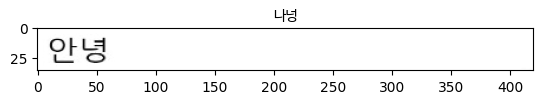

6


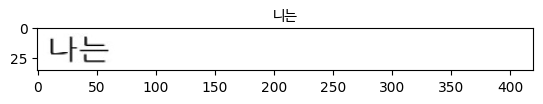

6


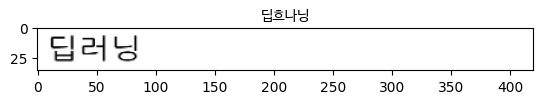

6


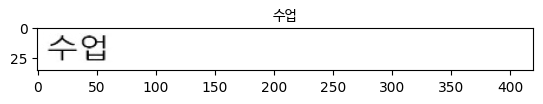

6


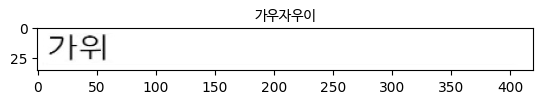

6


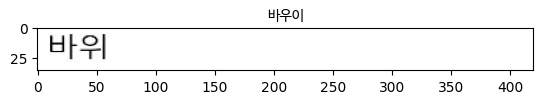

6


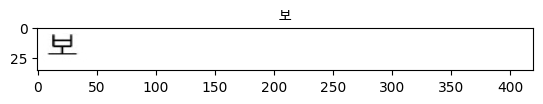

6


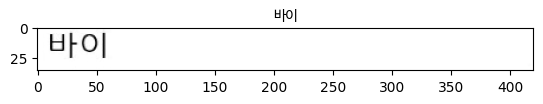

In [142]:
from models.layers import JamoCompose

#target_images = test_image2
# - (1) Encoder
encoder = Model(inputs, feature_seqs, 
                name='encoder')
num_feature = feature_seqs.shape.as_list()[-1]
#num_feature = np.array(feature_seqs).shape.as_list()[-1]

# - (2) Decoder
states_encoder_input = Input((None, num_feature),
                             name='states_encoder_input')
decoder_state_inputs = Input(shape=(n_state,), name='decoder_state')
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

jamo_embedding = jamo_embedding_layer(decoder_inputs)
states_decoder = gru_layer(jamo_embedding,
                           initial_state=decoder_state_inputs)
context, attention = dotattend([states_encoder_input,
                                states_decoder])
concat_state = Concatenate(axis=-1,name='concat_output')(
    [context, states_decoder])
predictions = jamo_clf(concat_state)
output_decoder = JamoCompose(name='jamocompose')(predictions)

decoder = Model([states_encoder_input,
                 decoder_inputs,
                 decoder_state_inputs], 
                [states_decoder, output_decoder], name='decoder')






# Calculate encoder results
states_encoder_ = encoder.predict(image_array)

EOS_TOKEN = ord('\n') # <EOS> token

# Decoder
batch_size = image_array.shape[0]

prev_inputs = np.ones((batch_size,1)) * EOS_TOKEN
prev_states = np.zeros((batch_size, n_state))

result = np.zeros([batch_size,0])

while True:

    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = predictions_
    
    result = np.concatenate([result, prev_inputs], axis=-1)
    
    print(result)

    if np.all(np.any(result==EOS_TOKEN,axis=1)):
        break

result = result[:,:].squeeze()
result = result.astype(np.int)


for image, seq in zip(image_array, result):

    #print(seq)
    text_seq = "".join([chr(char) for char in seq])
    print(len(text_seq))
    text_seq = text_seq.split('\n')[0]

    plt.title(text_seq,fontproperties=fontprop)
    plt.imshow(image[:,:,:],cmap='gray')
    plt.show()
